In [33]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from HPA_CC.data.dataset import RefCLSDM, load_labels, CellImageDataset
from HPA_CC.data.pipeline import create_data_path_index
from HPA_CC.models.train import find_checkpoint_file, PseudoRegressorLit, ClassifierLit
from HPA_CC.models.utils import regressor_inference
from HPA_CC.models.models import PseudoRegressor
from HPA_CC.utils.pseudotime import stretch_time
from HPA_CC.data.data_viz import save_image
from HPA_CC.utils.img_tools import get_batch_percentiles

from config import HOME, HPA_DS_PATH
classes = ["M-G1", "G1", "S-G2", "G2"]
dataset_name = "minimal"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
df = pd.read_csv(HOME / 'data' / 'ifimages_v23.csv')
print(df.columns)
df.head()

Index(['filename', 'jpg_prefix', 'if_plate_id', 'position', 'sample', 'status',
       'Image status name', 'locations', 'staining characteristics',
       'unspecific', 'antibody', 'ensembl_ids', 'gene_names', 'atlas_name',
       'versions', 'earliest_version', 'first_released', 'latest_version',
       'Spatial cell cycle', 'Intensity cell cycle', 'Annotated cell cycle',
       'gain', 'x_pos', 'y_pos', 'z_pos', 'Experiment state', 'Ab state',
       'Max tpm', 'Finished in genes', 'Protocol',
       'Gene reliability (in release)', 'Gene reliability (lims)',
       'Cell count', 'well_location_predictions_all'],
      dtype='object')


,filename,jpg_prefix,if_plate_id,position,sample,status,Image status name,locations,staining characteristics,unspecific,...,z_pos,Experiment state,Ab state,Max tpm,Finished in genes,Protocol,Gene reliability (in release),Gene reliability (lims),Cell count,well_location_predictions_all
0,/archive/1/1_A1_1_,https://lims.proteinatlas.org/images/992/1_A1_1_,1,A1,1,35,Annotated / Proteinatlas,Golgi apparatus,NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,16.13,ENSG00000066455,PFA,Supported,Supported,7.0,NaN
1,/archive/1/1_A1_2_,https://lims.proteinatlas.org/images/992/1_A1_2_,1,A1,2,35,Annotated / Proteinatlas,Golgi apparatus,NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,16.13,ENSG00000066455,PFA,Supported,Supported,6.0,NaN
2,/archive/1/1_A3_1_,https://lims.proteinatlas.org/images/2899/1_A3_1_,1,A3,1,35,Annotated / Proteinatlas,"Cytosol,Nucleoplasm",NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,2.74,ENSG00000183092,PFA,Approved,Approved,4.0,NaN
3,/archive/1/1_A3_2_,https://lims.proteinatlas.org/images/2899/1_A3_2_,1,A3,2,35,Annotated / Proteinatlas,"Cytosol,Nucleoplasm",NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,2.74,ENSG00000183092,PFA,Approved,Approved,6.0,NaN
4,/archive/1/1_A6_1_,https://lims.proteinatlas.org/images/609/1_A6_1_,1,A6,1,35,Annotated / Proteinatlas,"Endoplasmic reticulum,Nuclear membrane",NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,81.38,ENSG00000102119,PFA,Enhanced,Enhanced,5.0,NaN


In [35]:
print(df[["filename", "antibody", "gene_names"]].values[0])

['/archive/1/1_A1_1_' 'HPA000992' 'GOLGA5']


In [36]:
def prefix_to_well(filename):
    image_id = filename.split('/')[-1]
    return '_'.join(image_id.split('_')[:2])

df["well"] = df["filename"].apply(prefix_to_well)
print(df["well"].values)

['1_A1' '1_A1' '1_A3' ... '2172_F7' '2172_H8' '2172_H8']


In [37]:
CCD_prots = ["DUSP19", "DUSP18", "PAPSS1", "N6AMT1", "PHLDB1", "FLI1", "TTC21B", "PC", "UGDH", 
             "ORC6", "ZNF32", "CCNE1", "CCNB1", "AURKB", "BUB1B", "DPH2", "GMNN", "CDT1", "ANLN"]
ccd_rows = df["gene_names"].isin(CCD_prots) & df["atlas_name"].isin(["U2OS"])
ccd_df = df[ccd_rows]
print(ccd_df["filename"].values[0])
print(ccd_df[["well", "antibody", "gene_names"]].values[0])

/archive/91/91_H6_1_
['91_H6' 'HPA008419' 'BUB1B']


# Get HPA Image Prediction Annotations and Timeseries

In [38]:
# Pick a protein
protein = "ZNF32"
prot_well_names = ccd_df[ccd_df["gene_names"] == protein]["well"].unique()
prot_abs = ccd_df[ccd_df["gene_names"] == protein]["antibody"].unique()
print(prot_well_names)
print(prot_abs)

['1037_F11' '1562_C6']
['HPA059640' 'HPA039148']


Converting to RGB
Saved image samples to /home/ishang/HPA_CC/temp.png
Converting to RGB
Saved image samples to /home/ishang/HPA_CC/temp.png
Converting to RGB
Saved image samples to /home/ishang/HPA_CC/temp.png
Converting to RGB
Saved image samples to /home/ishang/HPA_CC/temp.png


<Figure size 640x480 with 0 Axes>

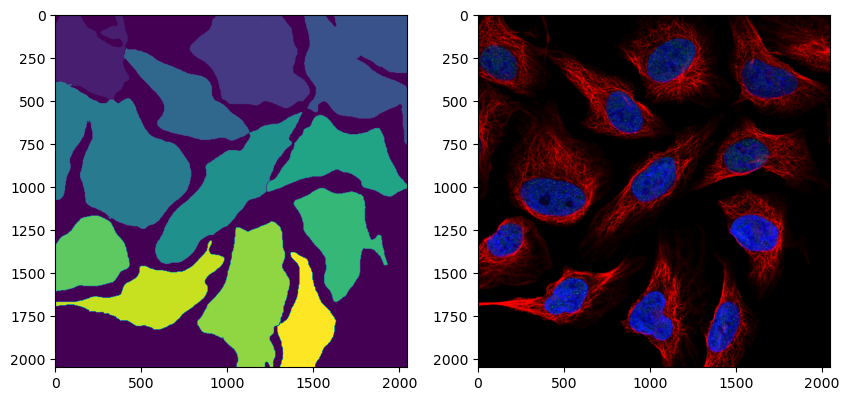

<Figure size 640x480 with 0 Axes>

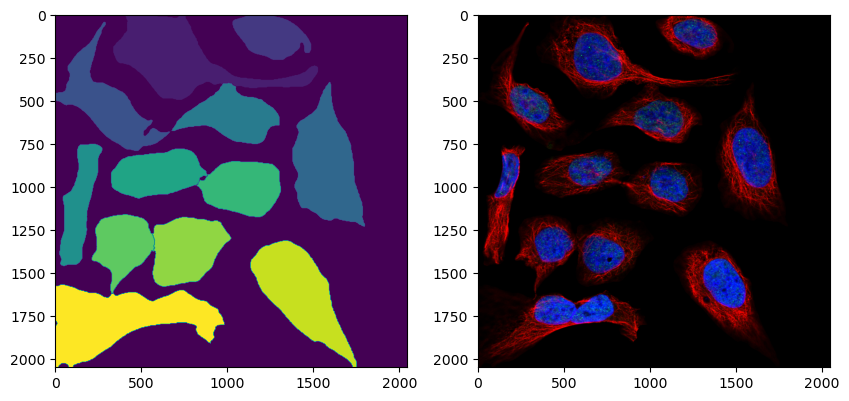

<Figure size 640x480 with 0 Axes>

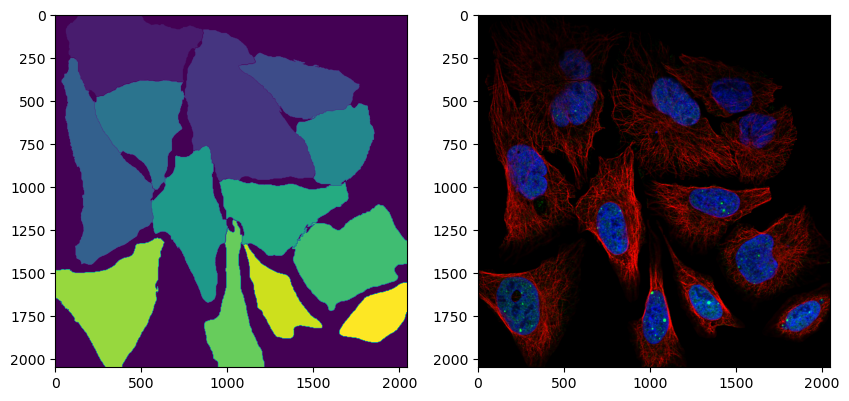

<Figure size 640x480 with 0 Axes>

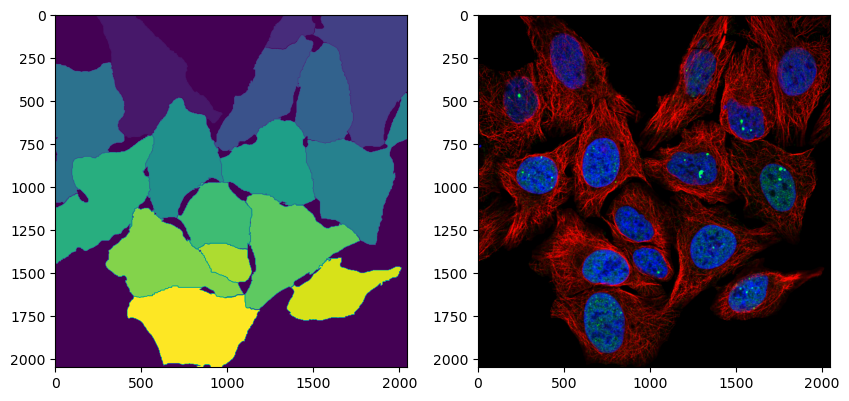

In [56]:
# prep data needed for model inference and visualization

image_paths = []
cell_mask_paths = []
for well in prot_well_names:
    image_paths.append(HPA_DS_PATH / well / f"imagesmin_max.npy")
    cell_mask_paths.append(HPA_DS_PATH / well / f"cell_masks_no_border_rm_1000_sharp_none.npy")

images = np.concatenate([np.load(p) for p in image_paths])

masks = [np.load(p) for p in cell_mask_paths]
n_per_well = [len(m) for m in masks]
# n_cell_per_well, i, j = [], 0, 0
# masks = np.concatenate(masks)
# while j < len(masks) and i < len(n_per_well):
#     n_cells = [len(np.unique(m)) - 1 for m in masks[j:j + n_per_well[i]]]
#     n_cell_per_well.append(sum(n_cells))
#     j += n_per_well[i]
#     i += 1

ref_images = images[:, :2, ...]
color_images = [save_image(torch.Tensor(I[[0, 1, 3]]), HOME / "temp.png", cmaps=["pure_blue", "pure_red", "pure_green"]) for I in images]

for i in range(len(color_images)):
    plt.clf()
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(masks[i])
    ax[1].imshow(color_images[i])
    plt.show()

sc_images = torch.concat([torch.load(HPA_DS_PATH / well / "images_minimal.pt") for well in prot_well_names])
assert len(sc_images) == sum([len(np.unique(m)) - 1 for m in masks])

from HPA_CC.data.well_normalization import buckets
percentiles = np.linspace(0, 100, buckets)
n, j, k = 0, 0, 0
well_intensities = []
for i in range(len(n_per_well)):
    k = j + n_per_well[i]
    well_images = ref_images[j:k]
    well_int_levels, _ = get_batch_percentiles(well_images.cpu().numpy(), percentiles)
    n_cells = sum([len(np.unique(m)) - 1 for m in masks[j:k]])
    well_intensities.extend([well_int_levels] * n_cells)
    j = k

# Load Models

In [40]:
log_dirs_home = Path("/data/ishang/pseudotime_pred/")

In [41]:
split = (0.64, 0.16, 0.2)
data_dir = Path("/data/ishang/all_HPA-CC-dataset/")
data_name = "minimal"
device = "cuda:0"

In [42]:
model_name = "HPA DINO Classifier"
model_hash = "1gu6u2qu" # hash of the model to use
repr_type = "hpa_dino" # "dino", "hpa_dino", or "conv"
ref_concat = True # for hpa_dino only, was this with concatenated cls tokens for each channel independently (default)
int_stats = True # were intensity statistics added to the embedding? (not used from conv)
label_type = "phase" # "phase", "angle", or "pseudotime"
scope = True # Only used for phase
checkpoint_file = find_checkpoint_file(model_hash, log_dirs_home, best=True)
phase_model = ClassifierLit.load_from_checkpoint(checkpoint_file)
phase_model.to(device)
phase_model.eval()
prot_phase_dataset = RefCLSDM(HPA_DS_PATH, f"minimal", batch_size=32, num_workers=1, split=None,
                              hpa=(repr_type == "hpa_dino"), label="phase", scope=scope, concat_well_stats=int_stats, 
                              inference=True)

Loading /data/ishang/all_HPA-CC-dataset/embeddings_temp_ZNF32_dino_hpa.pt


FileNotFoundError: [Errno 2] No such file or directory: '/data/ishang/all_HPA-CC-dataset/embeddings_temp_ZNF32_dino_hpa.pt'

In [ ]:
model_name = "HPA DINO Pseudotime Regressor"
model_hash = "81peszw2"
repr_type = "hpa_dino" # "dino", "hpa_dino", or "conv"
ref_concat = True # for hpa_dino only, was this with concatenated cls tokens for each channel independently (default)
int_stats = False # were intensity statistics added to the embedding? (not used from conv)
label_type = "pseudotime" # "phase", "angle", or "pseudotime"
scope = None
checkpoint_file = find_checkpoint_file(model_hash, log_dirs_home, best=True)
pseudo_model = PseudoRegressorLit.load_from_checkpoint(checkpoint_file)
pseudo_model.to(device)
pseudo_model.eval()
prot_pseudo_dataset = RefCLSDM(HPA_DS_PATH, f"temp_{protein}", batch_size=32, num_workers=1, split=None,
                              hpa=(repr_type == "hpa_dino"), label="pseudotime", concat_well_stats=int_stats, 
                              inference=True)

Loading /data/ishang/FUCCI-dataset-well/embeddings_minimal_dino_hpa.pt
Loading /data/ishang/FUCCI-dataset-well/minimal_sample_pseudotime.pt
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)
X shape: torch.Size([31732, 1536])
Y shape: torch.Size([31732])


In [ ]:
pseudo_preds = regressor_inference(pseudo_model, prot_pseudo_dataset.shared_dataloader(prot_pseudo_dataset.dataset))


Loading /data/ishang/FUCCI-dataset-well/minimal_sample_phase.pt
Loading /data/ishang/FUCCI-dataset-well/minimal_sample_pseudotime.pt


/home/ishang/miniconda3/envs/hpa-cc-copy/lib/python3.9/site-packages/torch/_inductor/compile_fx.py:135: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
